<a href="https://colab.research.google.com/github/blacksaturn1/RL_DQN_LunarLander/blob/main/RBE_595_LunarLander_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [1]:
!pip install swig
!pip install box2d-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp310-cp310-linux_x86_64.whl size=2373073 sha256=ff31cd01893bced52b689ba783175dcd48697288e8c5dd98f7bfd1a70b19c546
  Stored in directory: /root/.cache/pip/wheels/47/01/d2/6a780da77ccb98b1d2facdd520a8d10838a03b590f6f8d50c0
Successfully built box2d-py


In [2]:
!pip install gym[Box_2D]

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 17 05:37:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Imports

In [4]:
import gym
import random
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

# Helpers

In [5]:
import matplotlib.pyplot as plt


def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
import gym


def query_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

In [7]:
query_environment("LunarLander-v2")

Action Space: Discrete(4)
Observation Space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Load Env

In [8]:
env = gym.make('LunarLander-v2')
env.reset(seed=1)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


# Pytorch DQN

In [9]:
class DQN(nn.Module):
  def __init__(self,lr,input_dims, fc1_dims, fc2_dims, n_actions):
    super(DQN,self).__init__()
    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    self.n_actions=n_actions
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims)
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.n_actions)
    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self,state):
    x=F.relu(self.fc1(state))
    x2=F.relu(self.fc2(x))
    actions=self.fc3(x2)
    return actions







# Agent

In [10]:
class Agent():
  def __init__(self,gamma, epsilon, lr, input_dims, batchsize, n_actions,max_memory_size = 100000, eps_end=0.01, eps_decay=3e-4 ) -> None:
    self.gamma=gamma
    self.epsilon=epsilon
    self.eps_min=eps_end
    self.eps_decay = eps_decay
    self.lr=lr
    self.input_dims=input_dims
    self.batchsize=batchsize
    self.action_space = [i for i in range(n_actions)]
    self.max_memory_size=max_memory_size
    self.mem_counter = 0
    #self.Q_eval = DQN(self.lr,self.input_dims, 256, 256,n_actions)
    self.Q_eval = DQN(lr=self.lr, n_actions=n_actions, input_dims=self.input_dims, fc1_dims=256, fc2_dims=256)
    self.state_replay_buffer = np.zeros((self.max_memory_size, *input_dims),dtype=np.float32)
    self.new_states_buffer = np.zeros((self.max_memory_size, *input_dims),dtype=np.float32)
    self.action_buffer = np.zeros((self.max_memory_size),dtype=np.int16)
    self.reward_buffer = np.zeros((self.max_memory_size),dtype=np.float32)
    self.terminal_buffer = np.zeros((self.max_memory_size),dtype=bool)

  def store_transition(self, state, action, reward, state_next, done):
    index= self.mem_counter % self.max_memory_size
    self.state_replay_buffer[index] = state
    self.new_states_buffer[index] = state_next
    self.action_buffer[index] = action
    self.reward_buffer[index] = reward
    self.terminal_buffer[index] = done

    self.mem_counter+=1

  def get_action(self,observation):
    if np.random.random() >= self.epsilon:
      # state = T.tensor([observation]).to(self.Q_eval.device)
      state = T.tensor(np.array(observation)).to(self.Q_eval.device)

      actions = self.Q_eval.forward(state)
      action = T.argmax(actions).item()
    else:
      action = np.random.choice(self.action_space)

    return action

  def learn(self):
    if self.mem_counter < self.batchsize:
      return

    self.Q_eval.optimizer.zero_grad()
    max_memory = min(self.mem_counter, self.max_memory_size)
    batch = np.random.choice(max_memory, self.batchsize, replace=False)
    batch_idx = np.arange(self.batchsize, dtype=np.int32)

    state_batch = T.tensor(self.state_replay_buffer[batch]).to(self.Q_eval.device)
    new_states_batch = T.tensor(self.new_states_buffer[batch]).to(self.Q_eval.device)
    #action_buffer_batch = T.tensor(self.action_buffer[batch]).to(self.Q_eval.device)
    reward_buffer_batch = T.tensor(self.reward_buffer[batch]).to(self.Q_eval.device)
    terminal_buffer_batch = T.tensor(self.terminal_buffer[batch]).to(self.Q_eval.device)
    action_buffer_batch = self.action_buffer[batch]

    q_eval = self.Q_eval.forward(state_batch)[batch_idx, action_buffer_batch]
    q_next = self.Q_eval.forward(new_states_batch)
    q_next[terminal_buffer_batch] = 0
    q_target = reward_buffer_batch + self.gamma * T.max(q_next,dim = 1)[0]

    loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon - self.eps_decay if self.epsilon > self.eps_min\
                    else self.eps_min


# Learning

epsisode  0 score -217.65 avg_score -217.65 epsilon 1.00
epsisode  50 score -185.01 avg_score -144.07 epsilon 0.76
epsisode  100 score -5.87 avg_score -110.10 epsilon 0.46
epsisode  150 score -74.00 avg_score -76.17 epsilon 0.01
epsisode  200 score -106.90 avg_score -77.20 epsilon 0.01
epsisode  250 score -377.92 avg_score -73.60 epsilon 0.01
epsisode  300 score 219.58 avg_score -40.66 epsilon 0.01
epsisode  350 score -20.30 avg_score -2.56 epsilon 0.01
epsisode  400 score -148.30 avg_score 21.92 epsilon 0.01
epsisode  450 score 245.37 avg_score 61.91 epsilon 0.01
epsisode  500 score 268.61 avg_score 88.75 epsilon 0.01
epsisode  550 score 211.06 avg_score 61.80 epsilon 0.01
epsisode  600 score 218.44 avg_score 80.73 epsilon 0.01
epsisode  650 score 180.38 avg_score 144.84 epsilon 0.01
epsisode  700 score 209.68 avg_score 142.40 epsilon 0.01
epsisode  750 score -68.58 avg_score 113.28 epsilon 0.01
epsisode  800 score 233.60 avg_score 138.93 epsilon 0.01
epsisode  850 score 277.81 avg_sc

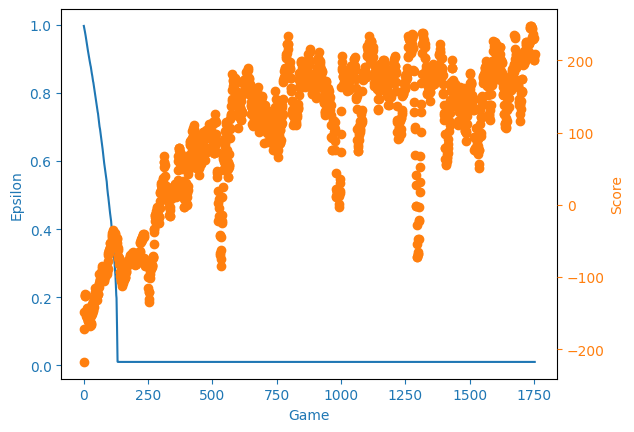

In [11]:
env = gym.make('LunarLander-v2')
agent = Agent(gamma=0.99, epsilon=1.0, batchsize=64, n_actions=4, eps_end=0.01, eps_decay=0.00005,input_dims=[8], lr= 0.003 )

avg_scores, scores, eps_history =[], [], []
num_games = 2000

for x in range(num_games):
  avg_score = 0
  score = 0
  done = False
  observation = env.reset()
  while not done:
    action = agent.get_action(observation)
    observation_next, reward, done, info = env.step(action)
    score += reward
    agent.store_transition(observation, action,reward,observation_next,done)
    agent.learn()
    observation = observation_next
  scores.append(score)
  eps_history.append(agent.epsilon)
  avg_score = np.mean(scores[-100:])
  if x%50==0:
    print ("epsisode ",x,"score %.2f"%score, "avg_score %.2f"%avg_score, "epsilon %.2f"%agent.epsilon)
  if x>1 and x%100==0:
    T.save(agent.Q_eval.state_dict(), 'checkpoint.pth')
  if avg_score>=200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(x-100, avg_score))
    T.save(agent.Q_eval.state_dict(), 'checkpoint.pth')
    break;

x = [i+1 for i in range(len(scores))]
filename = 'lunar_lander.png'
plotLearning(x,scores,eps_history,filename)





# Run Video

In [12]:
import base64, io
from collections import deque, namedtuple

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob


def show_video(env_name):
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = '{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="{}.mp4".format(env_name))
    agent.Q_eval.load_state_dict(T.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()

        action = agent.get_action(state)

        state, reward, done, _ = env.step(action)
    env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
#env = gym.make('LunarLander-v2')
agent = Agent(gamma=0.99, epsilon=0, batchsize=64, n_actions=4, eps_end=0, eps_decay=0.001,input_dims=[8], lr= 0.003 )

show_video_of_model(agent, 'LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 

In [14]:
show_video('LunarLander-v2')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
